In [1]:
import pickle
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
import numpy as np
import time
import itertools
import pandas as pd
from pandas import DataFrame as df
from matplotlib import pyplot as plt
import json
import os
from tqdm.notebook import tqdm
from elementary_reaction import *
from network2elementary import *

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') 

import networkx as nx
from joblib import Parallel, delayed
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

from class_reaction_templates import *

# Data loading

Reactions should have the information of reaction type defined as in NameRXN

In [4]:
reaction_example={1: {'name_rxn': '2.1.2',
      'name_rxn_def': 'Carboxylic acid + amine condensation',
    'smiles': '[CH3:1][CH:2]([NH2:3])[c:4]1[n:5][cH:6][cH:7][s:8]1.[NH2:9][C:10](=[O:11])[N:12]1[CH2:13][CH2:14][CH2:15][c:16]2[cH:17][c:18]([cH:19][n:20][c:21]21)-[c:22]1[cH:23][n:24][cH:25][c:26]([cH:27]1)[C:28](=[O:29])O>>[CH3:1][CH:2]([NH:3][C:28](=[O:29])[c:26]1[cH:25][n:24][cH:23][c:22]([cH:27]1)-[c:18]1[cH:19][n:20][c:21]2[c:16]([cH:17]1)[CH2:15][CH2:14][CH2:13][N:12]2[C:10]([NH2:9])=[O:11])[c:4]1[n:5][cH:6][cH:7][s:8]1'}}

# Find reaction

In [6]:
reaction_label='Carboxylic acid + amine condensation'

pistachio_key=[]
for key in tqdm(reaction_example.keys()):
    example=reaction_example[key]
    if example['name_rxn_def'] == reaction_label:
        pistachio_key.append(key)     
        
print(reaction_label)
print(len(pistachio_key))

  0%|          | 0/1 [00:00<?, ?it/s]

Carboxylic acid + amine condensation
1


In [7]:
def reaction_list(example_rxn_smiles, list_fragment=[],v=False,early_stop=True,adding_agents=False):
    RDLogger.DisableLog('rdApp.*') 
    
    if list_fragment:        reaction_list=[None]*(len(list_fragment)+1)
    try:
        if ' |' in example_rxn_smiles:
            example_rxn_smiles=example_rxn_smiles.rsplit(' |')[0]
        rxn = AllChem.ReactionFromSmarts(example_rxn_smiles)

        reactants, agents, products = [mols_from_smiles_list(x) for x in 
                                       [mols.split('.') for mols in example_rxn_smiles.split('>')]]
        [Chem.SanitizeMol(mol) for mol in reactants + agents + products]

        reactants_smiles=reactants+agents
        reactants_smiles=[Chem.MolToSmiles(remove_atom_map(mol)) for mol in reactants_smiles]

        find=0
        if list_fragment:
            for idx, fragments in enumerate(list_fragment):
                sub_match=0
                if v: print(fragments)
                for fragment in fragments:
                    if v: print(fragment)
                    patt= Chem.MolFromSmarts(fragment)
                    for smi in reactants_smiles:
                        mol = Chem.MolFromSmiles(smi)
                        if list(mol.GetSubstructMatch(patt)):
                            sub_match+=1
                            if adding_agents:
                                finding=mol
                            break
                if sub_match==len(fragments):
                    if adding_agents:
                        reactants_smi='.'.join([Chem.MolToSmiles(mol) for mol in reactants])
                        reactants_smi=reactants_smi+'.'+Chem.MolToSmiles(finding)
                        agents_smi='.'.join([Chem.MolToSmiles(mol) for mol in agents])
                        
                        products_smi='.'.join([Chem.MolToSmiles(mol) for mol in products])
                        example_rxn_smiles='>'.join([reactants_smi,agents_smi,products_smi])
                        
                    reaction_list[idx]=example_rxn_smiles
                    find+=1
                    if early_stop:
                        break
                    
            if find==0:
                reaction_list[-1]=example_rxn_smiles
            
        else:
            return [example_rxn_smiles]
    except Exception as e:
        if list_fragment:
            reaction_list[-1]=example_rxn_smiles
            return reaction_list
        else: return [example_rxn_smiles]
                          
    return reaction_list

In [9]:
try:
    list_fragment=class_reaction_templates[reaction_label]['Reagent']
except:
    list_fragment=[[]]
reactions=Parallel(n_jobs=23)(delayed(reaction_list)(reaction_example[key]['smiles'],list_fragment=list_fragment) for key in tqdm(pistachio_key))
classified_reactions=[[None] for x in range(len(list_fragment)+1)]

for reaction in reactions:
    for idx, class_reaction in enumerate(reaction):
        if class_reaction is not None:
            classified_reactions[idx].append(class_reaction)
            
for class_reaction in classified_reactions:
    class_reaction.remove(None)
for idx in range(len(list_fragment)+1):
    print('{} has {} reactions'.format(class_reaction_templates[reaction_label]['Reaction type'][idx],len(classified_reactions[idx])))

  0%|          | 0/1 [00:00<?, ?it/s]

Condensation using DCC has 0 reactions
Condensation without catalyst has 1 reactions


# Reaction visualization

[CH3:1][CH:2]([NH2:3])[c:4]1[n:5][cH:6][cH:7][s:8]1.[NH2:9][C:10](=[O:11])[N:12]1[CH2:13][CH2:14][CH2:15][c:16]2[cH:17][c:18]([cH:19][n:20][c:21]21)-[c:22]1[cH:23][n:24][cH:25][c:26]([cH:27]1)[C:28](=[O:29])O>>[CH3:1][CH:2]([NH:3][C:28](=[O:29])[c:26]1[cH:25][n:24][cH:23][c:22]([cH:27]1)-[c:18]1[cH:19][n:20][c:21]2[c:16]([cH:17]1)[CH2:15][CH2:14][CH2:13][N:12]2[C:10]([NH2:9])=[O:11])[c:4]1[n:5][cH:6][cH:7][s:8]1


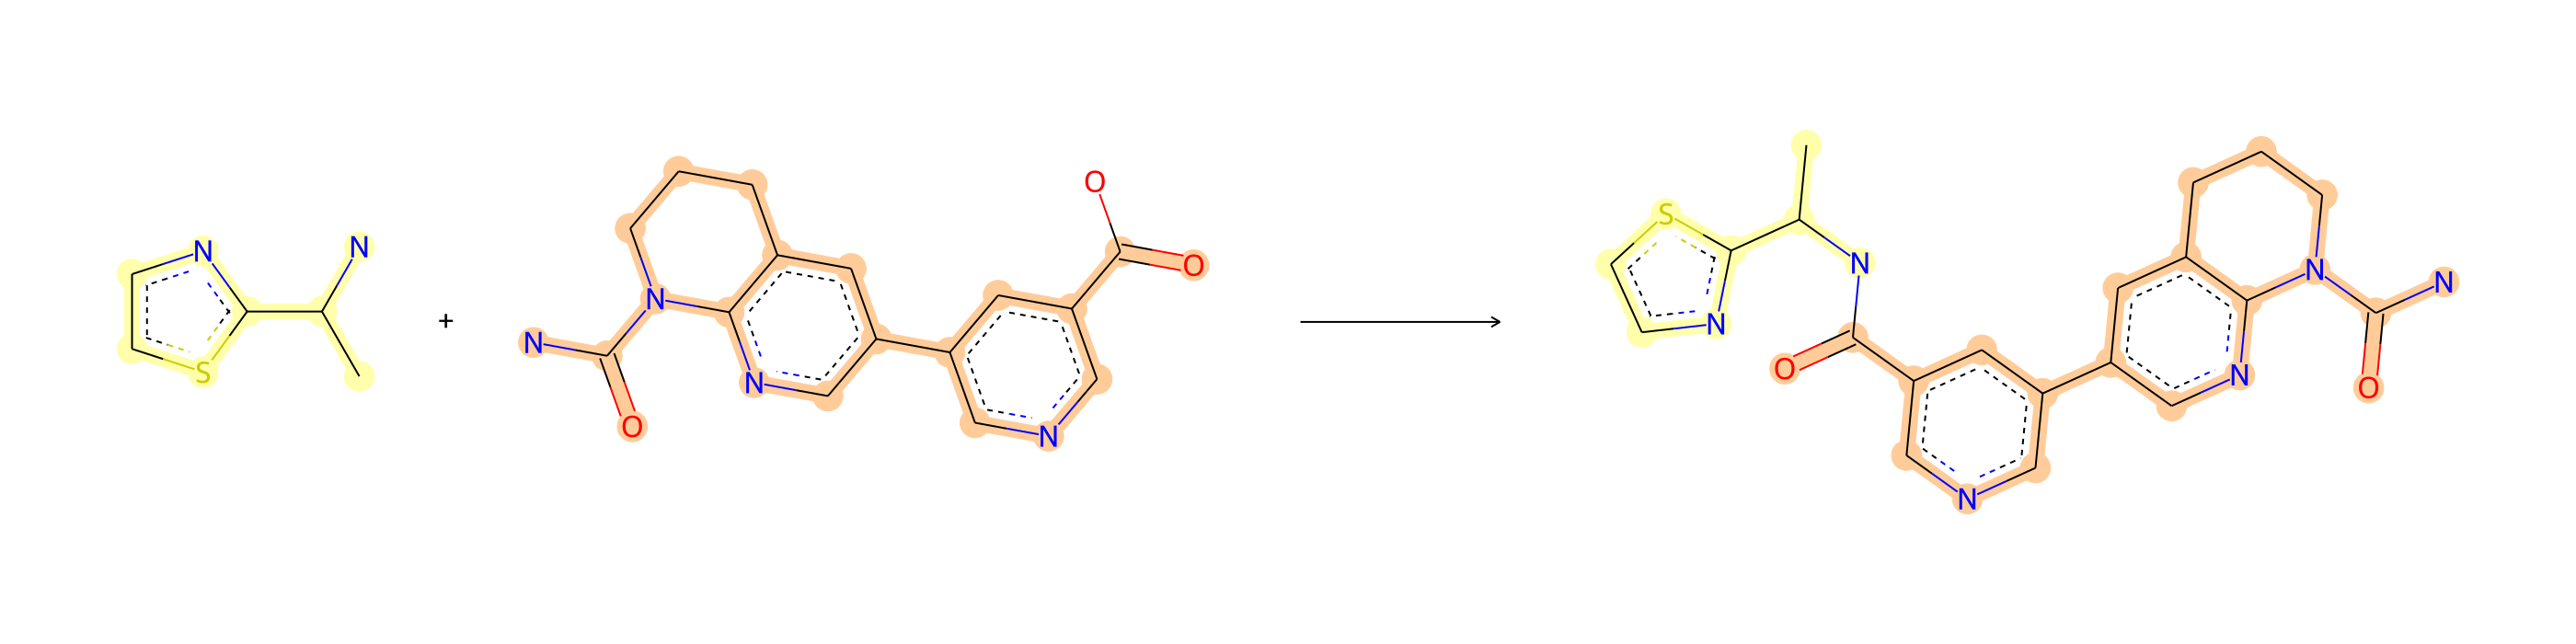

In [11]:
i=1
ii=0
example_smiles=classified_reactions[i][ii]
    
print(example_smiles)

if '>>' in example_smiles:
    reactant= example_smiles.split('>>')[0]
    product= example_smiles.split('>>')[1]
    reactant=Chem.MolToSmarts(Chem.MolFromSmiles(reactant))
    product=Chem.MolToSmarts(Chem.MolFromSmiles(product))
    example_smiles='>>'.join([reactant,product])
    example_rxn = AllChem.ReactionFromSmarts(example_smiles)

else:
    reactant= example_smiles.split('>')[0]
    reagent= example_smiles.split('>')[1]
    product= example_smiles.split('>')[2]
    reactant=Chem.MolToSmarts(Chem.MolFromSmiles(reactant))
    reagent=Chem.MolToSmarts(Chem.MolFromSmiles(reagent))
    product=Chem.MolToSmarts(Chem.MolFromSmiles(product))
    example_smiles='>'.join([reactant,reagent,product])
    example_rxn = AllChem.ReactionFromSmarts(example_smiles)

Draw.ReactionToImage(example_rxn,highlightByReactant=True, subImgSize=(700, 700))

# Make elementary step reactions

3


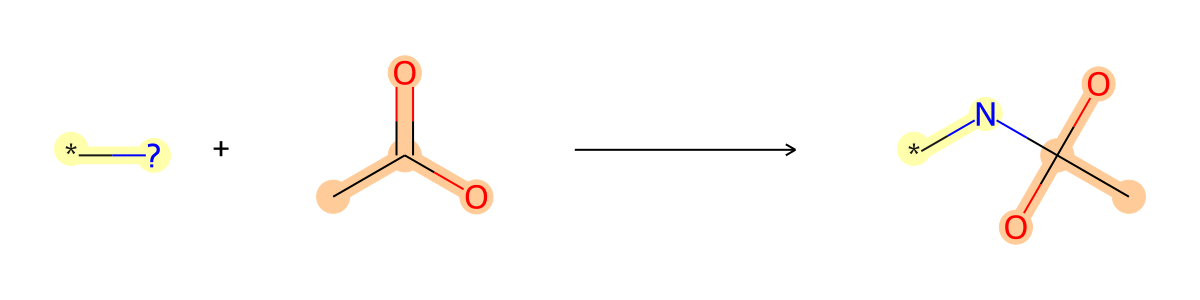

In [12]:
elem_reactions=class_reaction_templates[reaction_label]['Templates'][i]
print(len(elem_reactions))
Draw.ReactionToImage(AllChem.ReactionFromSmarts(elem_reactions[0][0]),highlightByReactant=True, subImgSize=(300, 300))

# Test mechanistic templates to reaction

In [15]:
reaction_list=classified_reactions[i]
example_smiles=reaction_list[ii]
print(example_smiles)    
rxn = AllChem.ReactionFromSmarts(example_smiles)   
reactants, agents, products = [mols_from_smiles_list(x) for x in 
                                [mols.split('.') for mols in example_smiles.split('>')]]
num_react,reaction_mixture, reaction_pair, reactant_pool=run_elementary_reaction(reactants+agents, elem_reactions,v=True)

print('Product is {}'.format([Chem.MolToSmiles(mol) for mol in products]))

[CH3:1][CH:2]([NH2:3])[c:4]1[n:5][cH:6][cH:7][s:8]1.[NH2:9][C:10](=[O:11])[N:12]1[CH2:13][CH2:14][CH2:15][c:16]2[cH:17][c:18]([cH:19][n:20][c:21]21)-[c:22]1[cH:23][n:24][cH:25][c:26]([cH:27]1)[C:28](=[O:29])O>>[CH3:1][CH:2]([NH:3][C:28](=[O:29])[c:26]1[cH:25][n:24][cH:23][c:22]([cH:27]1)-[c:18]1[cH:19][n:20][c:21]2[c:16]([cH:17]1)[CH2:15][CH2:14][CH2:13][N:12]2[C:10]([NH2:9])=[O:11])[c:4]1[n:5][cH:6][cH:7][s:8]1
This is step number 1 
Total molecules in the reactant pool are 2
This reaction is 1th of 1th.
Reaction template is [*:4]-[#7;!H0;+0:5].[O:1]-[C;H0;+0:14](-[#6:13])=[O:15]>>[#6:13]-[C;H0;+0:14](-[O;-1:15])(-[O:1])-[#7;+1:5]-[*:4]

For reactants ['CC(N)c1nccs1', 'NC(=O)N1CCCc2cc(-c3cncc(C(=O)O)c3)cnc21']
The 1 outcome of 1 outcomes

For prodcuts ['CC([NH2+]C([O-])(O)c1cncc(-c2cnc3c(c2)CCCN3C(N)=O)c1)c1nccs1']
[29O-][28C]([30OH])([3NH2+][2CH]([1CH3:1])[4c:4]1[5n:5][6cH:6][7cH:7][8s:8]1)[26c]1[25cH:25][24n:24][23cH:23][22c:22](-[18c:18]2[17cH:17][16c:16]3[21c:21]([20n:20][19cH:19]

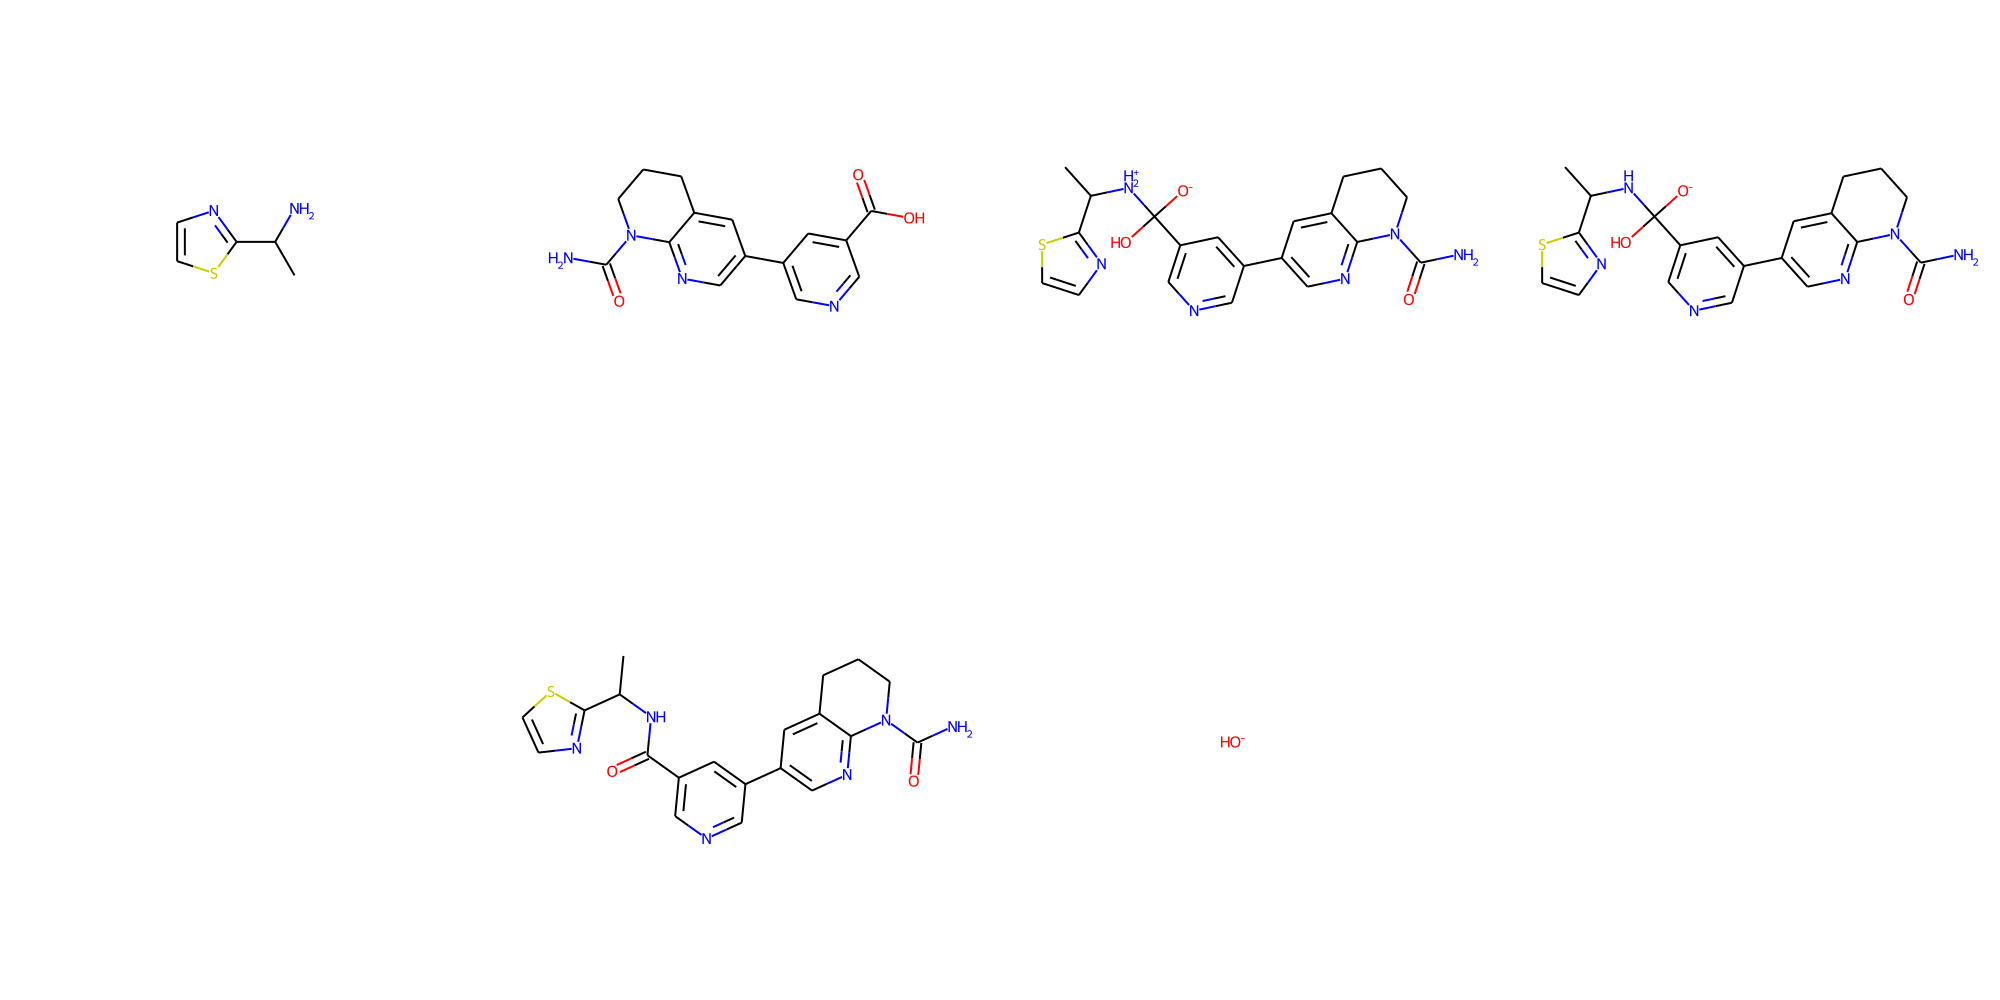

In [17]:
# All possible molecules
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(mol) for mol in reaction_mixture], subImgSize=(500, 500), molsPerRow=4, maxMols=len(reaction_mixture))

In [18]:
simple=True
G= reaction_graph(example_smiles, elem_reactions, v=False)
G

{'directed': True,
 'multigraph': False,
 'graph': {},
 'nodes': [{'SMILES': '[CH3:1][CH:2]([NH2:3])[c:4]1[n:5][cH:6][cH:7][s:8]1',
   'type': 'reactant',
   'unmapped_SMILES': 'CC(N)c1nccs1',
   'id': 0},
  {'type': 'Reaction', 'id': 1},
  {'SMILES': '[NH2:9][C:10](=[O:11])[N:12]1[CH2:13][CH2:14][CH2:15][c:16]2[cH:17][c:18](-[c:22]3[cH:23][n:24][cH:25][c:26]([C:28](=[O:29])[OH:30])[cH:27]3)[cH:19][n:20][c:21]21',
   'type': 'reactant',
   'unmapped_SMILES': 'NC(=O)N1CCCc2cc(-c3cncc(C(=O)O)c3)cnc21',
   'id': 2},
  {'SMILES': '[CH3:1][CH:2]([NH2+:3][C:28]([c:26]1[cH:25][n:24][cH:23][c:22](-[c:18]2[cH:17][c:16]3[c:21]([n:20][cH:19]2)[N:12]([C:10]([NH2:9])=[O:11])[CH2:13][CH2:14][CH2:15]3)[cH:27]1)([O-:29])[OH:30])[c:4]1[n:5][cH:6][cH:7][s:8]1',
   'type': 'intermediate',
   'unmapped_SMILES': 'CC([NH2+]C([O-])(O)c1cncc(-c2cnc3c(c2)CCCN3C(N)=O)c1)c1nccs1',
   'id': 3},
  {'type': 'Reaction', 'id': 4},
  {'SMILES': '[CH3:1][CH:2]([NH:3][C:28]([c:26]1[cH:25][n:24][cH:23][c:22](-[c:18]2[cH:

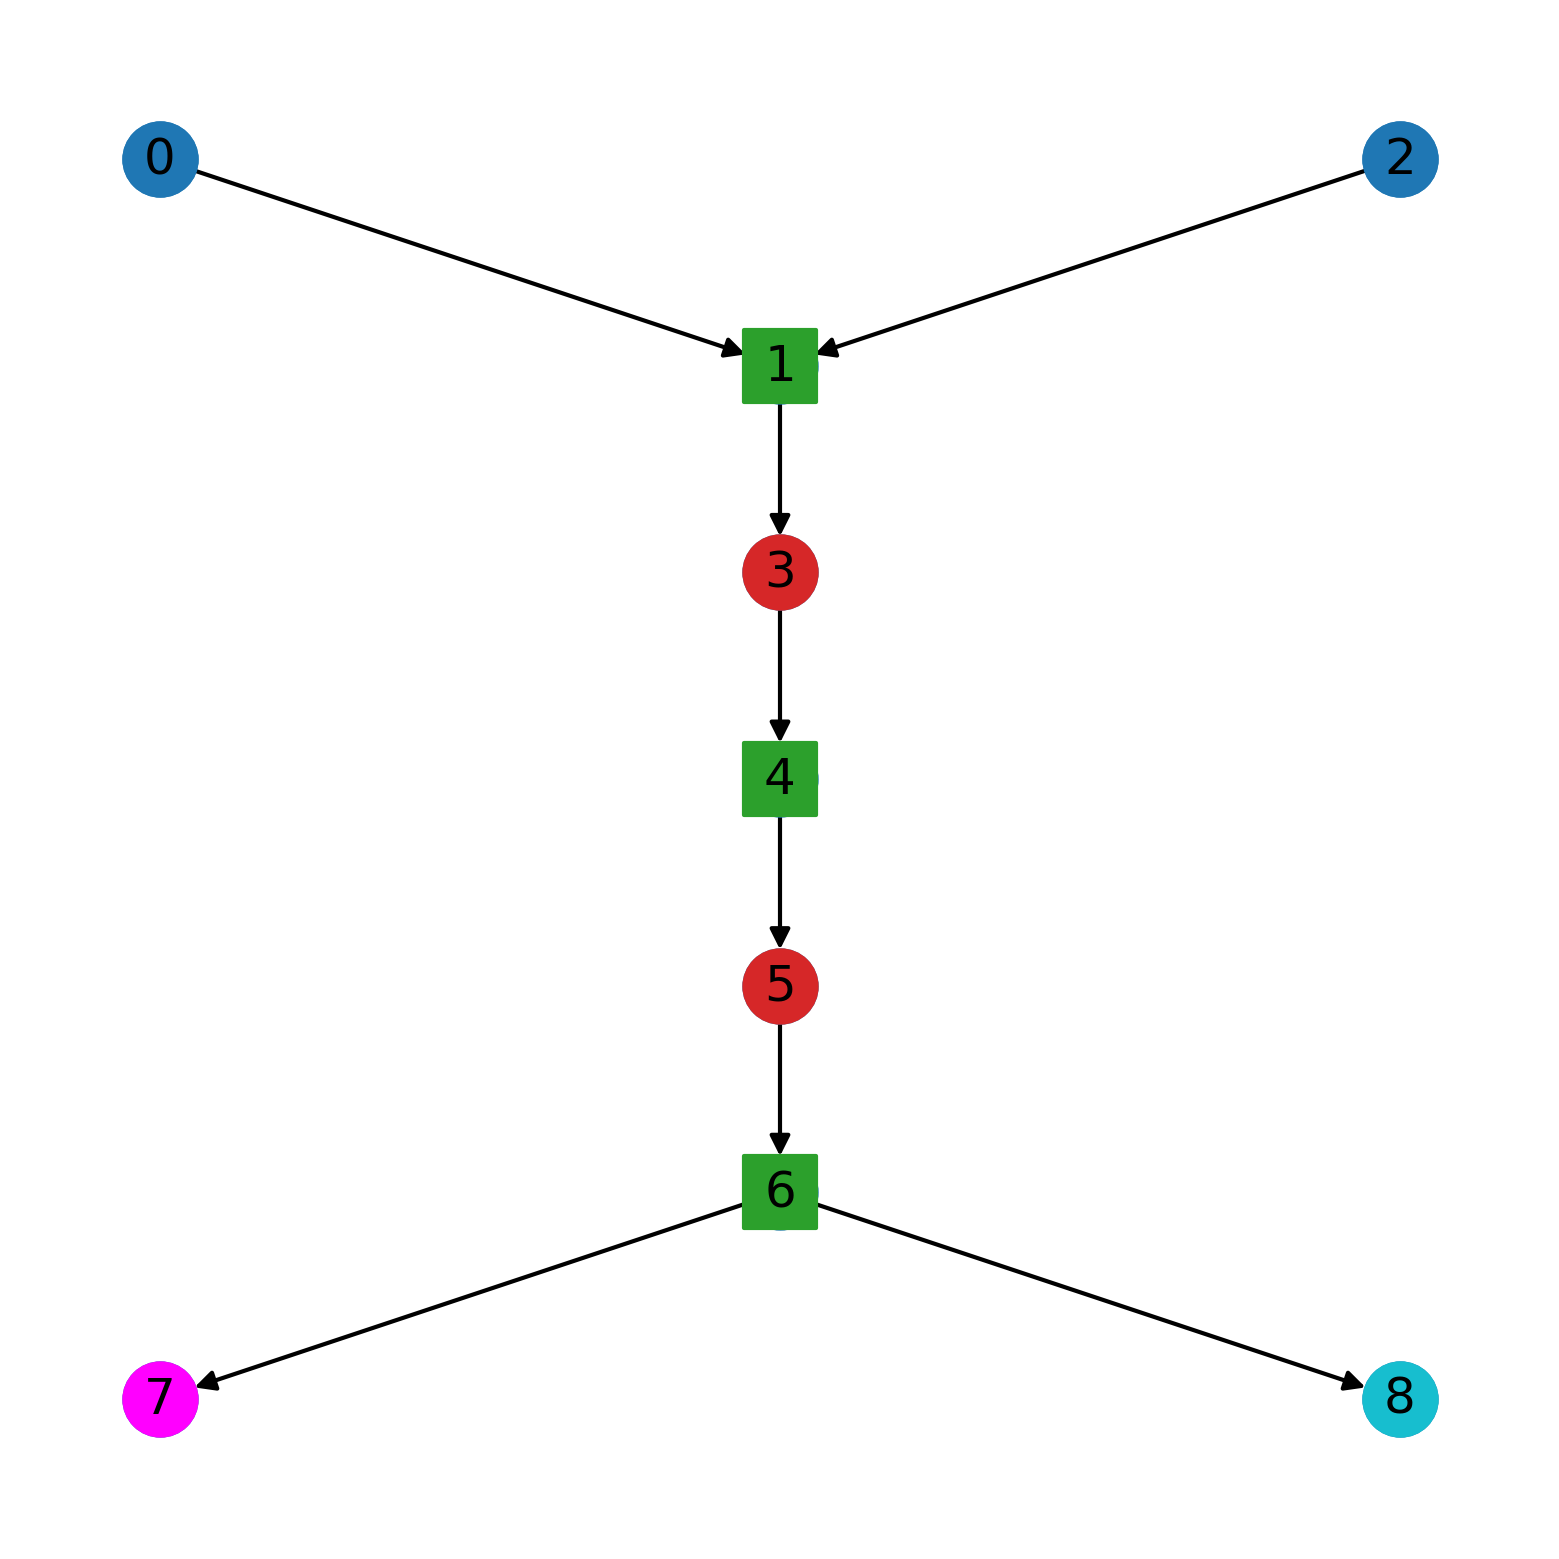

In [19]:
draw_reaction_graph(G, size=[5,5])

# Make mechanistic dataset for a reaction type

In [22]:
num_thread=10 
reaction_template=elem_reactions
G_list=Parallel(n_jobs=num_thread)(delayed(reaction_graph)(reaction, reaction_template) for reaction in tqdm(reaction_list))  #7880
res = [i for i in range(len(G_list)) if G_list[i] == None]
G_list=[x for x in G_list if x is not None]


print('Success: {} / {} ({:.2f} %)'.format(len(G_list),len(reaction_list), len(G_list)/len(reaction_list)*100))
print('Failed:  {} / {} ({:.2f} %)'.format(len(reaction_list)-len(G_list),len(reaction_list), 100-len(G_list)/len(reaction_list)*100))

  0%|          | 0/1 [00:00<?, ?it/s]

Success: 1 / 1 (100.00 %)
Failed:  0 / 1 (0.00 %)


In [30]:
with open(reaction_label+'_type_{}.pickle'.format(i), "wb") as file:
    pickle.dump(G_list, file)

# Save elementary reactions

In [31]:
if os.path.isfile(reaction_label+'_type_{}.pickle'.format(i)):
    with open(reaction_label+'_type_{}.pickle'.format(i), "rb") as fi2:
        elem_data=pickle.load(fi2)        
        
file  = open(reaction_label+'_type_{}_elementary_reaction.txt'.format(i), 'w' )

results=Parallel(n_jobs=23)(delayed(graph_to_elem_reaction)(reaction) for reaction in tqdm(elem_data))
flat_list = [item for sublist in results for item in sublist]
reactions='\n'.join(flat_list)

file.write(reactions)
file.close()      
print(len(flat_list))

  0%|          | 0/1 [00:00<?, ?it/s]

4


In [32]:
flat_list

['[CH3:1][CH:2]([NH2:3])[c:4]1[n:5][cH:6][cH:7][s:8]1.[NH2:9][C:10](=[O:11])[N:12]1[CH2:13][CH2:14][CH2:15][c:16]2[cH:17][c:18](-[c:22]3[cH:23][n:24][cH:25][c:26]([C:28](=[O:29])[OH:30])[cH:27]3)[cH:19][n:20][c:21]21>>[CH3:1][CH:2]([NH2+:3][C:28]([c:26]1[cH:25][n:24][cH:23][c:22](-[c:18]2[cH:17][c:16]3[c:21]([n:20][cH:19]2)[N:12]([C:10]([NH2:9])=[O:11])[CH2:13][CH2:14][CH2:15]3)[cH:27]1)([O-:29])[OH:30])[c:4]1[n:5][cH:6][cH:7][s:8]1',
 '[CH3:1][CH:2]([NH2+:3][C:28]([c:26]1[cH:25][n:24][cH:23][c:22](-[c:18]2[cH:17][c:16]3[c:21]([n:20][cH:19]2)[N:12]([C:10]([NH2:9])=[O:11])[CH2:13][CH2:14][CH2:15]3)[cH:27]1)([O-:29])[OH:30])[c:4]1[n:5][cH:6][cH:7][s:8]1>>[CH3:1][CH:2]([NH:3][C:28]([c:26]1[cH:25][n:24][cH:23][c:22](-[c:18]2[cH:17][c:16]3[c:21]([n:20][cH:19]2)[N:12]([C:10]([NH2:9])=[O:11])[CH2:13][CH2:14][CH2:15]3)[cH:27]1)([O-:29])[OH:30])[c:4]1[n:5][cH:6][cH:7][s:8]1',
 '[CH3:1][CH:2]([NH:3][C:28]([c:26]1[cH:25][n:24][cH:23][c:22](-[c:18]2[cH:17][c:16]3[c:21]([n:20][cH:19]2)[N:12]([C:10]

In [33]:
import math
from collections import defaultdict
import random

In [34]:
def get_bond_edits(rxn_smi):
    
    reactants = Chem.MolFromSmiles(rxn_smi.split('>')[0],sanitize=False)
    products  = Chem.MolFromSmiles(rxn_smi.split('>')[2],sanitize=False)

    conserved_maps = [a.GetIntProp('molAtomMapNumber') for a in reactants.GetAtoms() if a.GetIntProp('molAtomMapNumber')]
    bond_changes = set()

    bonds_prev = {}
    for bond in reactants.GetBonds():
        nums = sorted(
            [bond.GetBeginAtom().GetIntProp('molAtomMapNumber'), bond.GetEndAtom().GetIntProp('molAtomMapNumber')])
        bonds_prev['{}~{}'.format(nums[0], nums[1])] = bond.GetBondTypeAsDouble()
    bonds_new = {}
    for bond in products.GetBonds():
        nums = sorted(
            [bond.GetBeginAtom().GetIntProp('molAtomMapNumber'), bond.GetEndAtom().GetIntProp('molAtomMapNumber')])
        if (nums[0] not in conserved_maps) or (nums[1] not in conserved_maps): continue
        bonds_new['{}~{}'.format(nums[0], nums[1])] = bond.GetBondTypeAsDouble()

    for bond in bonds_prev:
        if bond not in bonds_new:
            bond_changes.add((bond.split('~')[0], bond.split('~')[1], 0.0)) # lost bond
        else:
            if bonds_prev[bond] != bonds_new[bond]:
                bond_changes.add((bond.split('~')[0], bond.split('~')[1], bonds_new[bond])) # changed bond
    for bond in bonds_new:
        if bond not in bonds_prev:
            bond_changes.add((bond.split('~')[0], bond.split('~')[1], bonds_new[bond]))  # new bond

    return bond_changes

def get_changed_formal(rxn_smi):
    
    reactants = Chem.MolFromSmiles(rxn_smi.split('>')[0],sanitize=False)
    products  = Chem.MolFromSmiles(rxn_smi.split('>')[2],sanitize=False)
    
    conserved_maps = [a.GetAtomMapNum() for a in products.GetAtoms() if a.HasProp('molAtomMapNumber')]
    formal_changes = set() # keep track of formal charge changes

    # Look at changed bonds
    formal_prev = {}
    for atom in reactants.GetAtoms():
        if atom.GetAtomMapNum() not in conserved_maps: continue
        formal_prev['{}'.format(atom.GetAtomMapNum())] = atom.GetFormalCharge()
        
    formal_new = {}
    for atom in products.GetAtoms():      
        formal_new['{}'.format(atom.GetAtomMapNum())] = atom.GetFormalCharge()
        
    for atom in formal_new:
        if formal_prev[atom] != formal_new[atom]:
            formal_changes.add((atom, formal_new[atom]-formal_prev[atom])) # changed formal charge
    return formal_changes

def get_changed_hydrogens(rxn_smi):
    
    reactants = Chem.MolFromSmiles(rxn_smi.split('>')[0],sanitize=False)
    products  = Chem.MolFromSmiles(rxn_smi.split('>')[2],sanitize=False)
    
    conserved_maps = [a.GetAtomMapNum() for a in products.GetAtoms() if a.HasProp('molAtomMapNumber')]
    hydrogen_changes = set() # keep track of Hydrogen changes

    # Look at changed bonds
    hydrogen_prev = {}
    for atom in reactants.GetAtoms():
        if atom.GetAtomMapNum() not in conserved_maps: continue
        hydrogen_prev['{}'.format(atom.GetAtomMapNum())] = atom.GetTotalNumHs()
        
    hydrogen_new = {}
    for atom in products.GetAtoms():      
        hydrogen_new['{}'.format(atom.GetAtomMapNum())] = atom.GetTotalNumHs()
        
    for atom in hydrogen_new:
        if hydrogen_prev[atom] != hydrogen_new[atom]:
            hydrogen_changes.add((atom, hydrogen_new[atom]-hydrogen_prev[atom])) # changed hydrogen
    
    return hydrogen_changes




In [35]:
def process_file(fpath, keep_invalid):

    non_continuous_reactions, five_plus_active_bond_reactions, wierd_changes, explicit_H  = 0, 0, 0, 0
    six_active_bond_reactions, seven_active_bond_reactions = 0, 0
    invalid_bonds, too_many_atoms, invalid_reactions = 0, 0, 0
    
    with open(fpath, 'r') as fid_in, open(fpath + '.proc', 'w') as fid_out:
        for line in tqdm(fid_in):
            retain = True
            rxn_smi = line.strip().split(' ')[0]
           
            try:
                bond_changes = get_bond_edits(rxn_smi)
                hydrogen_changes = get_changed_hydrogens(rxn_smi)
                formal_changes = get_changed_formal(rxn_smi)

                total_changes=set()
                total_changes.update(bond_changes)
                total_changes.update(hydrogen_changes)
                total_changes.update(formal_changes)
            except:
                wierd_changes+=1
                retain=False
            if check_invalid_bonds(bond_changes):
                invalid_bonds += 1
                retain = False
            elif check_non_continuous(bond_changes):
                non_continuous_reactions += 1
                retain = False
            elif '[H:' in rxn_smi.split('>')[0]:
                explicit_H += 1
                retain = False
            elif ':200]' in rxn_smi.split('>')[0]:
                too_many_atoms += 1
                retain = False
            elif len(bond_changes) > 4:
                five_plus_active_bond_reactions += 1
                if len(bond_changes) == 6:
                    six_active_bond_reactions += 1
                    retain = False
                elif len(bond_changes) >= 7:
                    seven_active_bond_reactions += 1
                    retain = False
                    
            if hydrogen_changes:
                for atom, changes in hydrogen_changes:
                    if changes !=1 and changes!=-1:
                        wierd_changes+=1
                        retain=False
                    
            if formal_changes:
                for atom, changes in formal_changes:
                    if changes !=1 and changes!=2 and changes!=-2 and changes!=-1:
                        wierd_changes+=1
                        retain=False
                    
            if not retain:
                invalid_reactions += 1
                if not keep_invalid:
                    continue
                    
            bond_string=';'.join(['{}-{}-{}'.format(x[0], x[1], x[2]) for x in bond_changes])
            hydrogen_string=';'.join(['{}:{}'.format(x[0], x[1]) for x in hydrogen_changes])
            formal_string=';'.join(['{}:{}'.format(x[0], x[1]) for x in formal_changes]) 
            fid_out.write('{} {}\n'.format(rxn_smi, '/'.join([bond_string, hydrogen_string, formal_string])))
    
    
    print(f'Finished processing {fpath}. \n')
    print(f'In total, there were {invalid_reactions} invalid reactions: \n')
    print(f'* {wierd_changes} reactions involved wierd changes \n')
    print(f'* {invalid_bonds} reactions involved one or more invalid bonds \n')
    print(f'* {non_continuous_reactions} reactions involved a non-continuous series of active bonds \n')
    print(f'* {explicit_H} reactions involved explicit hydrogens \n')
    print(f'* {too_many_atoms} reactions involved reaction smiles which are too long \n')
    print(f'* {five_plus_active_bond_reactions} reactions involved more than five active bonds '
          f'({six_active_bond_reactions} involved 6 and {seven_active_bond_reactions} involved 7 active bonds) \n')
    if not keep_invalid:
        print('\nThe invalid reactions have been filtered out. \n')
        


def check_non_continuous(bond_changes):
    atom_set = set()
    for bond in bond_changes:
        atom_set.add(bond[0])
        atom_set.add(bond[1])
    if len(atom_set) <= len(bond_changes) + 1:
        return False
    else:
        return True


def check_invalid_bonds(bond_changes):
    for bond in bond_changes:
        if bond[0] == bond[1]:
            return True
    return False

In [36]:
process_file("Carboxylic acid + amine condensation_type_1_elementary_reaction.txt", keep_invalid=False)

0it [00:00, ?it/s]

Finished processing Carboxylic acid + amine condensation_type_1_elementary_reaction.txt. 

In total, there were 0 invalid reactions: 

* 0 reactions involved wierd changes 

* 0 reactions involved one or more invalid bonds 

* 0 reactions involved a non-continuous series of active bonds 

* 0 reactions involved explicit hydrogens 

* 0 reactions involved reaction smiles which are too long 

* 0 reactions involved more than five active bonds (0 involved 6 and 0 involved 7 active bonds) 


The invalid reactions have been filtered out. 

